In [3]:
import tensorflow as tf
import time

with tf.device('/GPU:0'):  # Force GPU usage
    start = time.time()
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    end = time.time()

print("Time taken on GPU:", end - start)
print(tf.config.experimental.list_physical_devices('GPU'))
import tensorflow as tf
tf.keras.backend.clear_session()


Time taken on GPU: 0.018639087677001953
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

train_dir = ('train')
validation_dir = ('validation')
test_dir = ('test')



In [7]:
# Image preprocessing & data augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 2520 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


In [9]:
# Load MobileNetV2 without top layers
local_weights_path = "model/mobilenet_v2.h5"  # Path to your local file
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=local_weights_path)

# base_model.trainable = False  # Freeze base model layers

base_model.trainable = True  # Unfreeze the model
for layer in base_model.layers[:-20]:  # Keep first 20 layers frozen
    layer.trainable = False


# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(3, activation='softmax')(x)  # 3 classes (Rock, Paper, Scissors)

model = Model(inputs=base_model.input, outputs=out)



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


2025-04-03 08:59:08.001664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-03 08:59:08.012785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 347ms/step - accuracy: 0.9321 - loss: 0.1803 - val_accuracy: 0.7576 - val_loss: 3.8200
Epoch 2/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.9882 - loss: 0.0349 - val_accuracy: 0.6667 - val_loss: 9.0900
Epoch 3/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.9930 - loss: 0.0268 - val_accuracy: 0.6970 - val_loss: 11.0597
Epoch 4/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - accuracy: 0.9933 - loss: 0.0304 - val_accuracy: 0.6364 - val_loss: 11.4493
Epoch 5/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - accuracy: 0.9904 - loss: 0.0291 - val_accuracy: 0.8788 - val_loss: 2.8899
Epoch 6/6
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - accuracy: 0.9968 - loss: 0.0140 - val_accuracy: 0.9091 - val_loss: 1.8697


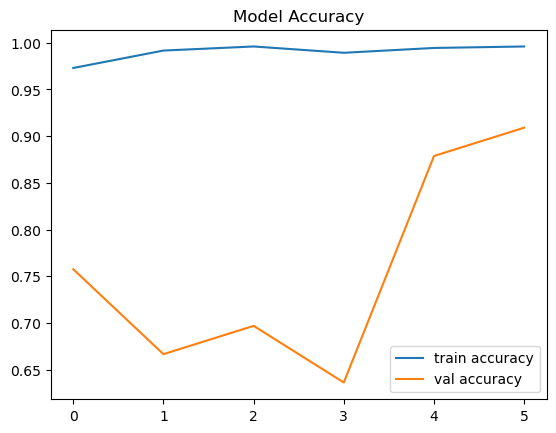

Found 372 images belonging to 3 classes.
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9948 - loss: 0.0148
Test Accuracy: 99.19%


In [11]:
# # Compile the model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=6,
    verbose=1,
    # callbacks=[checkpoint]
)


# Plot training results
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Test the model
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

2025-04-04 12:09:36.171662: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-04-04 12:09:36.171719: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-04 12:09:36.171726: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-04 12:09:36.171790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-04 12:09:36.171806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model loaded successfully!


2025-04-04 12:09:38.145714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-04 12:09:38.211936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


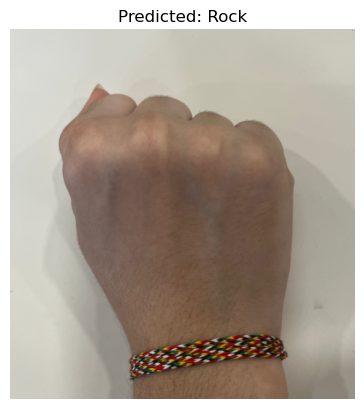

Model Prediction: Rock


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load the trained model
try:
    model = tf.keras.models.load_model("best_model.keras", compile=True)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Define class labels
class_names = ["Paper", "Rock", "Scissors"]  # Ensure correct order

# Function to preprocess image for model
def preprocess_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Load and resize
        img_array = image.img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize
        return img_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Function to predict and show the image with the prediction
def predict_and_show(img_path):
    img_array = preprocess_image(img_path)
    if img_array is None:
        print("Skipping prediction due to preprocessing error.")
        return

    # Get model prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]  # Get highest probability class

    # Read and display image using OpenCV
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Could not read image. Check the file path!")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"Model Prediction: {predicted_class}")

# Run prediction on a sample image
# Folders are "validation/name/img_name" -> png and out the folder -> jpg
predict_and_show("validation/sn2.png")  # Replace with actual image path
